 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) | CellphoneDB is a publicly available repository of curated receptors, ligands and their interactions.

# CellphoneDB method 2 (statistical analysis)
In this example we are using the method 2 (`statistical_analysis_method`) to study how cell-cell interactions change between a subset of immune cells and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. This method will retrieve interactions where the mean expression of the interacting partners (proteins participating in the interaction) displays significant cell state specificity by employing a random shuffling methodology. 

This notebook assumes that you either know how two **download CellphoneDB database or to create your own database**. If this is not the case, please check `T0_BuildDBfromFiles.ipynb` or `T0_BuildDBfromRelease.ipynb`. In this notebook we will explain how to run CellphoneDB for the **statistical method**.

### Check python version

In [1]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)
os.chdir('/path/to/working/directory')

Checking that environment contains a Python >= 3.8 as required by CellphoneDB.

In [2]:
print(sys.version)

3.8.18 (default, Sep 11 2023, 13:40:15) 
[GCC 11.2.0]


___
### Input files
The statistial method accepts 5 input files (3 mandatory).
- **cpdb_file_path**: (mandatory) path to the database `cellphonedb.zip`.
- **meta_file_path**: (mandatory) path to the meta file linking cell barcodes to cluster labels `metadata.tsv`.
- **counts_file_path**: (mandatory) paths to normalized counts file (not z-transformed), either in text format or h5ad (recommended) `normalised_log_counts.h5ad`.
- **microenvs_file_path** (optional) path to microenvironment file that groups cell clusters by microenvironments. When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within a microenvironment.
- **active_tf_path**: (optional) to the active transcription factors.

The `microenvs_file_path` content will depend on the biological question that the researcher wants to answer.

> In this **example** we are studying how cell-cell interactions change between a subset of immune cells and trophoblast cells as the trophoblast differentiate and invade the maternal uterus. This module will randomly permute the cluster labels of all cells whitin each microenvironement (`microenvs_file_path`), 1,000 times (default), to test whether the mean average receptor expression level in a cluster and the average ligand expression level between the interacting clusters is higher than those of the rest cell pairs. This procedure generates a P-value for the likelihood of cell-type specificity of a given receptor–ligand complex.

In [3]:
db_dir = "/path/to/v5.0.0"
data_dir = "/path/to/data"
sample = "EB"
#sample = "PBMC"
#sample = "GC"

cpdb_file_path = '%s/cellphonedb.zip'%db_dir
meta_file_path = '%s/metadata.%s.txt'%(data_dir, sample)
counts_file_path = '%s/%s.h5ad'%(data_dir, sample)
out_path = '/path/to/output/%s'%sample

"\ncpdb_file_path = 'db/v5/cellphonedb.zip'\nmeta_file_path = 'data/metadata.tsv'\ncounts_file_path = 'data/normalised_log_counts.h5ad'\nmicroenvs_file_path = 'data/microenvironment.tsv'\nactive_tf_path = 'data/active_TFs.tsv'\nout_path = 'results/method2_withScore'\n"

### Inspect input files

<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **cell_type**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t').rename(columns={"Cell": "barcode_sample"})
metadata.head(3)

,barcode_sample,cell_type
0,TAACAGCCAAGATTGATGGC_1,CD4+ T
1,TAACAGCCAAGACTCACCTT_1,CD4+ T
2,TAACAGCCAAAGCAGGCAGC_1,CD8+ T


<span style="color:green">**2)**</span>  The **counts** files is a scanpy h5ad object. The dimensions and order of this object must coincide with the dimensions of the metadata file (i.e. must have the same number of cells in both files).

In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(22986, 32888)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['barcode_sample']).sort()

True

____
### Run statistical analysis
The output of this method will be saved in `output_path` and also returned to the predefined variables.

> The statisical method allows the user to downsample the data with the aim of speeding up the results (subsampling arguments). To this end, CellphoneDB employs a geometric sketching procedure (Hie *et al.* 2019) to preserve the structure of the data without losing information from lowly represented cells. For this tutorial, we have opted to manually downsample the count matrix and the metadata file accordingly.

In [70]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    #active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    #microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 1000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.1,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 70,                                     # number of threads to use in the analysis.
    debug_seed = 42,                                 # debug randome seed. To disable >=0.
    result_precision = 3,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
/share/home/yangxiujia/1_PROJECTS/20210412-B_Cell_Dev_Stage_Profiling/03-Single-Cell-v2/seurat_pipeline5/CCI_analysis/CellPhoneDB/EB.h5ad
/share/home/yangxiujia/1_PROJECTS/20210412-B_Cell_Dev_Stage_Profiling/03-Single-Cell-v2/seurat_pipeline5/CCI_analysis/CellPhoneDB/metadata.EB.txt
[ ][CORE][21/11/23-09:17:19][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:42 Threads:70 Precision:3
[ ][CORE][21/11/23-09:17:19][WARNING] Debug random seed enabled. Set to 42
[ ][CORE][21/11/23-09:17:23][INFO] Running Real Analysis
[ ][CORE][21/11/23-09:17:24][INFO] Running Statistical Analysis


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [28:30<00:00,  1.71s/it]


[ ][CORE][21/11/23-09:46:01][INFO] Building Pvalues result
[ ][CORE][21/11/23-09:46:07][INFO] Building results
[ ][CORE][21/11/23-09:46:07][INFO] Scoring interactions: Filtering genes per cell type..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:04<00:00,  9.31it/s]

[ ][CORE][21/11/23-09:46:12][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 31.97it/s]


[ ][CORE][21/11/23-09:46:14][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1444/1444 [00:30<00:00, 46.99it/s]


Saved deconvoluted to results-v2/EB/statistical_analysis_deconvoluted_11_21_2023_094654.txt
Saved deconvoluted_percents to results-v2/EB/statistical_analysis_deconvoluted_percents_11_21_2023_094654.txt
Saved means to results-v2/EB/statistical_analysis_means_11_21_2023_094654.txt
Saved pvalues to results-v2/EB/statistical_analysis_pvalues_11_21_2023_094654.txt
Saved significant_means to results-v2/EB/statistical_analysis_significant_means_11_21_2023_094654.txt
Saved interaction_scores to results-v2/EB/statistical_analysis_interaction_scores_11_21_2023_094654.txt


In [53]:
from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path = cpdb_file_path,           # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,           # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,       # mandatory: normalized count matrix.
    counts_data = 'hgnc_symbol',               # defines the gene annotation in counts matrix.
    #microenvs_file_path = microenvs_file_path, # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                 # optional: whether to score interactions or not. 
    output_path = out_path,                    # Path to save results    microenvs_file_path = None,
    separator = '|',                           # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    threads = 40,                               # number of threads to use in the analysis.
    threshold = 0.1,                           # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                      # Sets the rounding for the mean values in significan_means.
    debug = False,                             # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_suffix = None                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
)

[ ][CORE][20/11/23-20:45:44][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
/share/home/yangxiujia/1_PROJECTS/20210412-B_Cell_Dev_Stage_Profiling/03-Single-Cell-v2/seurat_pipeline5/CCI_analysis/CellPhoneDB/GC.h5ad
/share/home/yangxiujia/1_PROJECTS/20210412-B_Cell_Dev_Stage_Profiling/03-Single-Cell-v2/seurat_pipeline5/CCI_analysis/CellPhoneDB/metadata.GC.txt
[ ][CORE][20/11/23-20:45:56][INFO] Running Basic Analysis
[ ][CORE][20/11/23-20:45:57][INFO] Building results
[ ][CORE][20/11/23-20:45:57][INFO] Scoring interactions: Filtering genes per cell type..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 31.94it/s]

[ ][CORE][20/11/23-20:45:57][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 109.05it/s]


[ ][CORE][20/11/23-20:45:58][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [00:10<00:00, 27.40it/s]


Saved means_result to results-v2/GC/simple_analysis_means_result_11_20_2023_204611.txt
Saved deconvoluted to results-v2/GC/simple_analysis_deconvoluted_11_20_2023_204611.txt
Saved deconvoluted_percents to results-v2/GC/simple_analysis_deconvoluted_percents_11_20_2023_204611.txt
Saved interaction_scores to results-v2/GC/simple_analysis_interaction_scores_11_20_2023_204611.txt


Results are save into the predefined file and as a dictionary in the `cpdb_results` variable.

In [71]:
list(cpdb_results.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'pvalues',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted',
 'interaction_scores']

___
### Description of output files
Most output files share common columns:
- **id_cp_interaction**: Unique CellphoneDB identifier for each interaction stored in the database.
- **interacting_pair**: Name of the interacting pairs separated by “|”.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **secreted**: True if one of the partners is secreted.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **annotation_strategy**: Curated if the interaction was annotated by the CellphoneDB developers. Otherwise, the name of the database where the interaction has been downloaded from.
- **is_integrin**: True if one of the partners is integrin.
- **directionality**: Indiicates the directionality of the interaction and the charactersitics of the interactors.
- **classification**: Pathway classification for the interacting partners.

**Pvalues** fields:
- **cell_a|cell_b**: 1 if interaction is detected as significant, 0 if not.

In [72]:
cpdb_results['pvalues'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,CD14+ monocyte|CD14+ monocyte,CD14+ monocyte|CD16+ monocyte,CD14+ monocyte|CD27-IgM+IgD+ memory B,CD14+ monocyte|CD4+ T,CD14+ monocyte|CD8+ T,CD14+ monocyte|CLP,CD14+ monocyte|CMP,CD14+ monocyte|Classical memory B,CD14+ monocyte|Cycling pre B,CD14+ monocyte|Cycling pro B,CD14+ monocyte|Erythroblast,CD14+ monocyte|Erythrocyte,CD14+ monocyte|FOShi naive B,CD14+ monocyte|FTLhi immature B,CD14+ monocyte|GMP,CD14+ monocyte|HSC,CD14+ monocyte|IgM+ memory B,CD14+ monocyte|Immature B,CD14+ monocyte|MAIT,CD14+ monocyte|MEP,CD14+ monocyte|MSC,CD14+ monocyte|Macrophage,CD14+ monocyte|Megakaryocyte,CD14+ monocyte|Myeloblast,CD14+ monocyte|Myelocyte,CD14+ monocyte|NK,CD14+ monocyte|Naive B,CD14+ monocyte|Neutrophil,CD14+ monocyte|PB,CD14+ monocyte|PC,CD14+ monocyte|Pre B,CD14+ monocyte|Pre-pro B,CD14+ monocyte|Pro B,CD14+ monocyte|Pro-myelocyte,CD14+ monocyte|S100A8hi immature B,CD14+ monocyte|Treg,CD14+ monocyte|cDC,...,cDC|Naive B,cDC|Neutrophil,cDC|PB,cDC|PC,cDC|Pre B,cDC|Pre-pro B,cDC|Pro B,cDC|Pro-myelocyte,cDC|S100A8hi immature B,cDC|Treg,cDC|cDC,cDC|pDC,pDC|CD14+ monocyte,pDC|CD16+ monocyte,pDC|CD27-IgM+IgD+ memory B,pDC|CD4+ T,pDC|CD8+ T,pDC|CLP,pDC|CMP,pDC|Classical memory B,pDC|Cycling pre B,pDC|Cycling pro B,pDC|Erythroblast,pDC|Erythrocyte,pDC|FOShi naive B,pDC|FTLhi immature B,pDC|GMP,pDC|HSC,pDC|IgM+ memory B,pDC|Immature B,pDC|MAIT,pDC|MEP,pDC|MSC,pDC|Macrophage,pDC|Megakaryocyte,pDC|Myeloblast,pDC|Myelocyte,pDC|NK,pDC|Naive B,pDC|Neutrophil,pDC|PB,pDC|PC,pDC|Pre B,pDC|Pre-pro B,pDC|Pro B,pDC|Pro-myelocyte,pDC|S100A8hi immature B,pDC|Treg,pDC|cDC,pDC|pDC
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [73]:
cpdb_results['pvalues']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,CD14+ monocyte|CD14+ monocyte,CD14+ monocyte|CD16+ monocyte,CD14+ monocyte|CD27-IgM+IgD+ memory B,CD14+ monocyte|CD4+ T,CD14+ monocyte|CD8+ T,CD14+ monocyte|CLP,CD14+ monocyte|CMP,CD14+ monocyte|Classical memory B,CD14+ monocyte|Cycling pre B,CD14+ monocyte|Cycling pro B,CD14+ monocyte|Erythroblast,CD14+ monocyte|Erythrocyte,CD14+ monocyte|FOShi naive B,CD14+ monocyte|FTLhi immature B,CD14+ monocyte|GMP,CD14+ monocyte|HSC,CD14+ monocyte|IgM+ memory B,CD14+ monocyte|Immature B,CD14+ monocyte|MAIT,CD14+ monocyte|MEP,CD14+ monocyte|MSC,CD14+ monocyte|Macrophage,CD14+ monocyte|Megakaryocyte,CD14+ monocyte|Myeloblast,CD14+ monocyte|Myelocyte,CD14+ monocyte|NK,CD14+ monocyte|Naive B,CD14+ monocyte|Neutrophil,CD14+ monocyte|PB,CD14+ monocyte|PC,CD14+ monocyte|Pre B,CD14+ monocyte|Pre-pro B,CD14+ monocyte|Pro B,CD14+ monocyte|Pro-myelocyte,CD14+ monocyte|S100A8hi immature B,CD14+ monocyte|Treg,CD14+ monocyte|cDC,...,cDC|Naive B,cDC|Neutrophil,cDC|PB,cDC|PC,cDC|Pre B,cDC|Pre-pro B,cDC|Pro B,cDC|Pro-myelocyte,cDC|S100A8hi immature B,cDC|Treg,cDC|cDC,cDC|pDC,pDC|CD14+ monocyte,pDC|CD16+ monocyte,pDC|CD27-IgM+IgD+ memory B,pDC|CD4+ T,pDC|CD8+ T,pDC|CLP,pDC|CMP,pDC|Classical memory B,pDC|Cycling pre B,pDC|Cycling pro B,pDC|Erythroblast,pDC|Erythrocyte,pDC|FOShi naive B,pDC|FTLhi immature B,pDC|GMP,pDC|HSC,pDC|IgM+ memory B,pDC|Immature B,pDC|MAIT,pDC|MEP,pDC|MSC,pDC|Macrophage,pDC|Megakaryocyte,pDC|Myeloblast,pDC|Myelocyte,pDC|NK,pDC|Naive B,pDC|Neutrophil,pDC|PB,pDC|PC,pDC|Pre B,pDC|Pre-pro B,pDC|Pro B,pDC|Pro-myelocyte,pDC|S100A8hi immature B,pDC|Treg,pDC|cDC,pDC|pDC
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,CPI-SC0D3C12C3F,COL11A2_integrin_a2b1_complex,simple:P13942,complex:integrin_a2b1_complex,COL11A2,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,CPI-SC0B86B7CED,COL12A1_integrin_a2b1_complex,simple:Q99715,complex:integrin_a2b1_complex,COL12A1,NaN,True,False,False,curated,Tru

**Means** fields:

- **means**: Mean values for all the interacting partners: mean value refers to the total mean of the individual partner average expression values in the corresponding interacting pairs of cell types. If one of the mean values is 0, then the total mean is set to 0.

In [12]:
cpdb_results['means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,CD14+ monocyte|CD14+ monocyte,CD14+ monocyte|CD16+ monocyte,CD14+ monocyte|CD27-IgM+IgD+ memory B,CD14+ monocyte|CD4+ T,CD14+ monocyte|CD8+ T,CD14+ monocyte|Classical memory B,CD14+ monocyte|FOShi naive B,CD14+ monocyte|IgM+ memory B,CD14+ monocyte|MAIT,CD14+ monocyte|Macrophage,CD14+ monocyte|Megakaryocyte,CD14+ monocyte|NK,CD14+ monocyte|Naive B,CD14+ monocyte|Neutrophil,CD14+ monocyte|PC,CD14+ monocyte|Treg,CD14+ monocyte|cDC,CD14+ monocyte|gd T,CD14+ monocyte|pDC,CD16+ monocyte|CD14+ monocyte,CD16+ monocyte|CD16+ monocyte,CD16+ monocyte|CD27-IgM+IgD+ memory B,CD16+ monocyte|CD4+ T,CD16+ monocyte|CD8+ T,CD16+ monocyte|Classical memory B,CD16+ monocyte|FOShi naive B,CD16+ monocyte|IgM+ memory B,CD16+ monocyte|MAIT,CD16+ monocyte|Macrophage,CD16+ monocyte|Megakaryocyte,CD16+ monocyte|NK,CD16+ monocyte|Naive B,CD16+ monocyte|Neutrophil,CD16+ monocyte|PC,CD16+ monocyte|Treg,CD16+ monocyte|cDC,CD16+ monocyte|gd T,...,cDC|IgM+ memory B,cDC|MAIT,cDC|Macrophage,cDC|Megakaryocyte,cDC|NK,cDC|Naive B,cDC|Neutrophil,cDC|PC,cDC|Treg,cDC|cDC,cDC|gd T,cDC|pDC,gd T|CD14+ monocyte,gd T|CD16+ monocyte,gd T|CD27-IgM+IgD+ memory B,gd T|CD4+ T,gd T|CD8+ T,gd T|Classical memory B,gd T|FOShi naive B,gd T|IgM+ memory B,gd T|MAIT,gd T|Macrophage,gd T|Megakaryocyte,gd T|NK,gd T|Naive B,gd T|Neutrophil,gd T|PC,gd T|Treg,gd T|cDC,gd T|gd T,gd T|pDC,pDC|CD14+ monocyte,pDC|CD16+ monocyte,pDC|CD27-IgM+IgD+ memory B,pDC|CD4+ T,pDC|CD8+ T,pDC|Classical memory B,pDC|FOShi naive B,pDC|IgM+ memory B,pDC|MAIT,pDC|Macrophage,pDC|Megakaryocyte,pDC|NK,pDC|Naive B,pDC|Neutrophil,pDC|PC,pDC|Treg,pDC|cDC,pDC|gd T,pDC|pDC
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.044,0.0,0.0,0.148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055,0.054,0.0,0.0,0.054,0.0,0.0,0.158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
cpdb_results['significant_means'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,rank,CD14+ monocyte|CD14+ monocyte,CD14+ monocyte|CD16+ monocyte,CD14+ monocyte|CD27-IgM+IgD+ memory B,CD14+ monocyte|CD4+ T,CD14+ monocyte|CD8+ T,CD14+ monocyte|Classical memory B,CD14+ monocyte|FOShi naive B,CD14+ monocyte|IgM+ memory B,CD14+ monocyte|MAIT,CD14+ monocyte|Macrophage,CD14+ monocyte|Megakaryocyte,CD14+ monocyte|NK,CD14+ monocyte|Naive B,CD14+ monocyte|Neutrophil,CD14+ monocyte|PC,CD14+ monocyte|Treg,CD14+ monocyte|cDC,CD14+ monocyte|gd T,CD14+ monocyte|pDC,CD16+ monocyte|CD14+ monocyte,CD16+ monocyte|CD16+ monocyte,CD16+ monocyte|CD27-IgM+IgD+ memory B,CD16+ monocyte|CD4+ T,CD16+ monocyte|CD8+ T,CD16+ monocyte|Classical memory B,CD16+ monocyte|FOShi naive B,CD16+ monocyte|IgM+ memory B,CD16+ monocyte|MAIT,CD16+ monocyte|Macrophage,CD16+ monocyte|Megakaryocyte,CD16+ monocyte|NK,CD16+ monocyte|Naive B,CD16+ monocyte|Neutrophil,CD16+ monocyte|PC,CD16+ monocyte|Treg,CD16+ monocyte|cDC,...,cDC|IgM+ memory B,cDC|MAIT,cDC|Macrophage,cDC|Megakaryocyte,cDC|NK,cDC|Naive B,cDC|Neutrophil,cDC|PC,cDC|Treg,cDC|cDC,cDC|gd T,cDC|pDC,gd T|CD14+ monocyte,gd T|CD16+ monocyte,gd T|CD27-IgM+IgD+ memory B,gd T|CD4+ T,gd T|CD8+ T,gd T|Classical memory B,gd T|FOShi naive B,gd T|IgM+ memory B,gd T|MAIT,gd T|Macrophage,gd T|Megakaryocyte,gd T|NK,gd T|Naive B,gd T|Neutrophil,gd T|PC,gd T|Treg,gd T|cDC,gd T|gd T,gd T|pDC,pDC|CD14+ monocyte,pDC|CD16+ monocyte,pDC|CD27-IgM+IgD+ memory B,pDC|CD4+ T,pDC|CD8+ T,pDC|Classical memory B,pDC|FOShi naive B,pDC|IgM+ memory B,pDC|MAIT,pDC|Macrophage,pDC|Megakaryocyte,pDC|NK,pDC|Naive B,pDC|Neutrophil,pDC|PC,pDC|Treg,pDC|cDC,pDC|gd T,pDC|pDC
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,CPI-SC0BB68FB34,COL9A3_integrin_a2b1_complex,simple:Q14050,complex:integrin_a2b1_complex,COL9A3,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Interaction scores** fields:
- **scores**: scores ranging from 0 to 100. The higher the score is,  the more specific the interaction is expected to be.

In [14]:
cpdb_results['interaction_scores'].head(2)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,CD14+ monocyte|CD14+ monocyte,CD14+ monocyte|CD16+ monocyte,CD14+ monocyte|CD27-IgM+IgD+ memory B,CD14+ monocyte|CD4+ T,CD14+ monocyte|CD8+ T,CD14+ monocyte|Classical memory B,CD14+ monocyte|FOShi naive B,CD14+ monocyte|IgM+ memory B,CD14+ monocyte|MAIT,CD14+ monocyte|Macrophage,CD14+ monocyte|Megakaryocyte,CD14+ monocyte|NK,CD14+ monocyte|Naive B,CD14+ monocyte|Neutrophil,CD14+ monocyte|PC,CD14+ monocyte|Treg,CD14+ monocyte|cDC,CD14+ monocyte|gd T,CD14+ monocyte|pDC,CD16+ monocyte|CD14+ monocyte,CD16+ monocyte|CD16+ monocyte,CD16+ monocyte|CD27-IgM+IgD+ memory B,CD16+ monocyte|CD4+ T,CD16+ monocyte|CD8+ T,CD16+ monocyte|Classical memory B,CD16+ monocyte|FOShi naive B,CD16+ monocyte|IgM+ memory B,CD16+ monocyte|MAIT,CD16+ monocyte|Macrophage,CD16+ monocyte|Megakaryocyte,CD16+ monocyte|NK,CD16+ monocyte|Naive B,CD16+ monocyte|Neutrophil,CD16+ monocyte|PC,CD16+ monocyte|Treg,CD16+ monocyte|cDC,CD16+ monocyte|gd T,...,cDC|IgM+ memory B,cDC|MAIT,cDC|Macrophage,cDC|Megakaryocyte,cDC|NK,cDC|Naive B,cDC|Neutrophil,cDC|PC,cDC|Treg,cDC|cDC,cDC|gd T,cDC|pDC,gd T|CD14+ monocyte,gd T|CD16+ monocyte,gd T|CD27-IgM+IgD+ memory B,gd T|CD4+ T,gd T|CD8+ T,gd T|Classical memory B,gd T|FOShi naive B,gd T|IgM+ memory B,gd T|MAIT,gd T|Macrophage,gd T|Megakaryocyte,gd T|NK,gd T|Naive B,gd T|Neutrophil,gd T|PC,gd T|Treg,gd T|cDC,gd T|gd T,gd T|pDC,pDC|CD14+ monocyte,pDC|CD16+ monocyte,pDC|CD27-IgM+IgD+ memory B,pDC|CD4+ T,pDC|CD8+ T,pDC|Classical memory B,pDC|FOShi naive B,pDC|IgM+ memory B,pDC|MAIT,pDC|Macrophage,pDC|Megakaryocyte,pDC|NK,pDC|Naive B,pDC|Neutrophil,pDC|PC,pDC|Treg,pDC|cDC,pDC|gd T,pDC|pDC
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,True,Adhesion-Adhesion,Adhesion by Cadherin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,True,Adhesion-Adhesion,Adhesion by Collagen/Integrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**CellSign** fields:
- **interacting_pair**: Name of the interacting pairs.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **TF relationship**: a 1 denotes that the TF downstream the receptor is active.

**Deconvoluted** fields:
- **gene_name**: Gene identifier for one of the subunits that are participating in the interaction defined in “means.csv” file. The identifier will depend on the input of the user list.
- **uniprot**: UniProt identifier for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **is_complex**: True if the subunit is part of a complex. Single if it is not, complex if it is.
- **protein_name**: Protein name for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **complex_name**: Complex name if the subunit is part of a complex. Empty if not.
- **mean**: Mean expression of the corresponding gene in each cluster.

In [16]:
cpdb_results['deconvoluted'].head(2)

,gene_name,uniprot,is_complex,protein_name,complex_name,id_cp_interaction,gene,CD14+ monocyte,CD16+ monocyte,CD27-IgM+IgD+ memory B,CD4+ T,CD8+ T,Classical memory B,FOShi naive B,IgM+ memory B,MAIT,Macrophage,Megakaryocyte,NK,Naive B,Neutrophil,PC,Treg,cDC,gd T,pDC
multidata_id,,,,,,,,,,,,,,,,,,,,,,,,,,
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS09B8977D7,UBASH3B,0.049,0.26,0.172,0.05,0.024,0.002,0.01,0.013,0.041,0.0,0.153,0.036,0.019,0.073,0.022,0.047,0.047,0.005,0.0
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS05760BB78,UBASH3B,0.049,0.26,0.172,0.05,0.024,0.002,0.01,0.013,0.041,0.0,0.153,0.036,0.019,0.073,0.022,0.047,0.047,0.005,0.0


In [4]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
eb_b_lst = ["Pre-pro B", "Cycling pro B", "Pro B", "Cycling pre B", "Pre B", 
            "Immature B", "FTLhi immature B", "S100A8hi immature B", 
            "Naive B", "FOShi naive B", 
            "Classical memory B", "IgM+ memory B", "CD27-IgM+IgD+ memory B", "PB", "PC"]
eb_nb_lst = ["HSC", "CMP", "GMP", "MEP", "CLP",
         "CD4+ T", "CD8+ T", "MAIT", "Treg", "NK",
         "CD14+ monocyte", "CD16+ monocyte", "Macrophage", "cDC", "pDC",
             "Pro-myelocyte", "Myelocyte", "Myeloblast", "Neutrophil",
         "Erythroblast", "Erythrocyte", "Megakaryocyte",
         "MSC"]

/share/home/yangxiujia/.conda/envs/cpdb_v5/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap


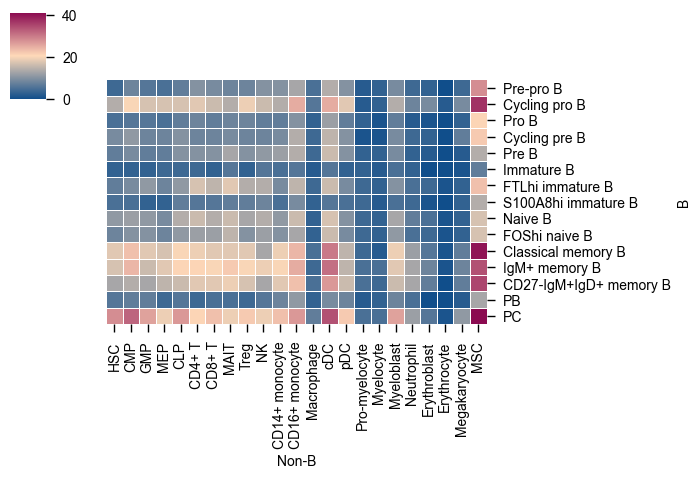

In [143]:
# Import the p value file
df = pd.read_csv("/path/to/EB/statistical_analysis_pvalues_11_21_2023_094654.txt", sep="\t")

# Generate CCI matrix table
b_lst = []
nb_lst = []
count_lst = []
for b in eb_b_lst:
    for nb in eb_nb_lst:
        b_lst.append(b)
        nb_lst.append(nb)
        '''
        count = sum((df_p.loc[:,"%s|%s"%(b, nb)]<0.05) | (df_p.loc[:,"%s|%s"%(nb, b)]<0.05))
        '''
        df_temp1 = df[(df.receptor_a==True) & (df.receptor_b==False)]
        df_temp1 = df_temp1[(df_temp1.loc[:,"%s|%s"%(b, nb)]<0.05).tolist()]
        df_temp2 = df[(df.receptor_a==False) & (df.receptor_b==True)]
        df_temp2 = df_temp2[(df_temp2.loc[:,"%s|%s"%(nb, b)]<0.05).tolist()]
        df_temp3 = df[(df.directionality=="Adhesion-Adhesion") | df.classification.str.contains("Adhesion")]
        df_temp3 = df_temp3[(df_temp3.loc[:,["%s|%s"%(b, nb), "%s|%s"%(nb, b)]]<0.05).sum(axis=1)>0]
        n_temp = len(set(pd.concat([df_temp1, df_temp2, df_temp3])["id_cp_interaction"].tolist()))
        count_lst.append(n_temp)
df_mat = pd.DataFrame({"B": b_lst, "Non-B": nb_lst, "Count": count_lst}).pivot(index="B", columns="Non-B", values="Count")


# Make the visualization
import seaborn as sns
from ktplotspy.utils.support import diverging_palette

low_col = "#104e8b"
mid_col = "#ffdab9"
high_col = "#8b0a50"
colmap = diverging_palette(low=low_col, medium=mid_col, high=high_col)
sns.clustermap(
            df_mat.loc[eb_b_lst,eb_nb_lst], square=True,
            row_cluster=False,
            col_cluster=False,
            linewidths=0.5,
            tree_kws={"linewidths": 0}, #annot=True,
            cmap=colmap, figsize=(7.1,4.8)#, vmin=0, vmax=80
        )

/share/home/yangxiujia/.conda/envs/cpdb_v5/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap


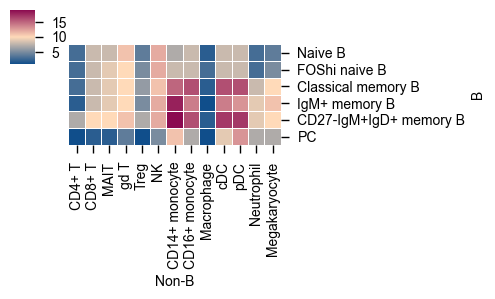

In [158]:
import matplotlib.pyplot as plt
# Import the p value file
df = pd.read_csv("/path/to/PBMC/statistical_analysis_pvalues_11_20_2023_202338.txt", sep="\t")
pb_b_lst = [ "Naive B", "FOShi naive B",
            "Classical memory B", "IgM+ memory B", "CD27-IgM+IgD+ memory B", "PC"]
pb_nb_lst = ["CD4+ T", "CD8+ T", "MAIT", "gd T", "Treg", "NK",
         "CD14+ monocyte", "CD16+ monocyte", "Macrophage", "cDC", "pDC",
              "Neutrophil", "Megakaryocyte"]

# Generate CCI matrix table
b_lst = []
nb_lst = []
count_lst = []
for b in pb_b_lst:
    for nb in pb_nb_lst:
        b_lst.append(b)
        nb_lst.append(nb)
        '''
        count = sum((df_p.loc[:,"%s|%s"%(b, nb)]<0.05) | (df_p.loc[:,"%s|%s"%(nb, b)]<0.05))
        '''
        df_temp1 = df[(df.receptor_a==True) & (df.receptor_b==False)]
        df_temp1 = df_temp1[(df_temp1.loc[:,"%s|%s"%(b, nb)]<0.05).tolist()]
        df_temp2 = df[(df.receptor_a==False) & (df.receptor_b==True)]
        df_temp2 = df_temp2[(df_temp2.loc[:,"%s|%s"%(nb, b)]<0.05).tolist()]
        df_temp3 = df[(df.directionality=="Adhesion-Adhesion") | df.classification.str.contains("Adhesion")]
        df_temp3 = df_temp3[(df_temp3.loc[:,["%s|%s"%(b, nb), "%s|%s"%(nb, b)]]<0.05).sum(axis=1)>0]
        n_temp = len(set(pd.concat([df_temp1, df_temp2, df_temp3])["id_cp_interaction"].tolist()))
        count_lst.append(n_temp)
        #print(b, nb, count)
df_mat = pd.DataFrame({"B": b_lst, "Non-B": nb_lst, "Count": count_lst}).pivot(index="B", columns="Non-B", values="Count")


# Make the visualization
import seaborn as sns
from ktplotspy.utils.support import diverging_palette

low_col = "#104e8b"
mid_col = "#ffdab9"
high_col = "#8b0a50"
colmap = diverging_palette(low=low_col, medium=mid_col, high=high_col)
sns.clustermap(
            df_mat.loc[pb_b_lst,pb_nb_lst], square=True,
            row_cluster=False,
            col_cluster=False,
            linewidths=0.5,
            tree_kws={"linewidths": 0}, #annot=True,
            cmap=colmap, figsize=(5,3) #, vmin=0, vmax=50
        )


/share/home/yangxiujia/.conda/envs/cpdb_v5/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap


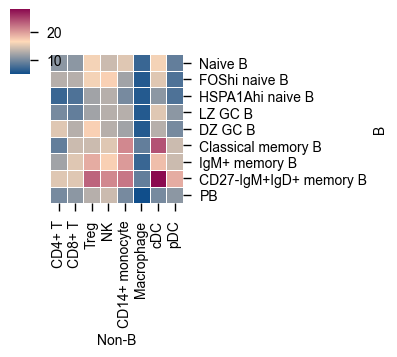

In [154]:
# Import the p value file
df = pd.read_csv("/path/to/GC/statistical_analysis_pvalues_11_20_2023_205114.txt", sep="\t")
gc_b_lst = ["Naive B", "FOShi naive B", "HSPA1Ahi naive B", 
            "LZ GC B", "DZ GC B",
            "Classical memory B", "IgM+ memory B", "CD27-IgM+IgD+ memory B", "PB"]
gc_nb_lst = [
         "CD4+ T", "CD8+ T", "Treg", "NK",
         "CD14+ monocyte", "Macrophage", "cDC", "pDC"]

# Generate CCI matrix table
b_lst = []
nb_lst = []
count_lst = []
for b in gc_b_lst:
    for nb in gc_nb_lst:
        b_lst.append(b)
        nb_lst.append(nb)
        '''
        count = sum((df_p.loc[:,"%s|%s"%(b, nb)]<0.05) | (df_p.loc[:,"%s|%s"%(nb, b)]<0.05))
        '''
        df_temp1 = df[(df.receptor_a==True) & (df.receptor_b==False)]
        df_temp1 = df_temp1[(df_temp1.loc[:,"%s|%s"%(b, nb)]<0.05).tolist()]
        df_temp2 = df[(df.receptor_a==False) & (df.receptor_b==True)]
        df_temp2 = df_temp2[(df_temp2.loc[:,"%s|%s"%(nb, b)]<0.05).tolist()]
        df_temp3 = df[(df.directionality=="Adhesion-Adhesion") | df.classification.str.contains("Adhesion")]
        df_temp3 = df_temp3[(df_temp3.loc[:,["%s|%s"%(b, nb), "%s|%s"%(nb, b)]]<0.05).sum(axis=1)>0]
        n_temp = len(set(pd.concat([df_temp1, df_temp2, df_temp3])["id_cp_interaction"].tolist()))
        count_lst.append(n_temp)
        
df_mat = pd.DataFrame({"B": b_lst, "Non-B": nb_lst, "Count": count_lst}).pivot(index="B", columns="Non-B", values="Count")


# Make the visualization
import seaborn as sns
from ktplotspy.utils.support import diverging_palette

low_col = "#104e8b"
mid_col = "#ffdab9"
high_col = "#8b0a50"
colmap = diverging_palette(low=low_col, medium=mid_col, high=high_col)
sns.clustermap(
            df_mat.loc[gc_b_lst,gc_nb_lst], square=True,
            row_cluster=False,
            col_cluster=False,
            linewidths=0.5,
            tree_kws={"linewidths": 0}, 
            cmap=colmap, figsize=(4,3.6) #, vmin=0, vmax=50
        )